In [29]:
import pandas as pd
from matplotlib import pyplot as plt
import glob
import matplotlib.dates as mdates
import numpy as np
from datetime import timedelta
from tqdm import tqdm

Define Functions

In [30]:
def reader(path, first_var):
    '''
    Reads SEMS/DASH data, adds datetime columns

    :param path: path to data file
    :param first_var: the name of the fir column label
    :return: pandas DataFrame
    '''
    # Open the file and read the lines
    skip=1
    with open(path, "r") as file:
        # Iterate over the lines
        for line in file:
            # rip leading and trailing whitespace
            line = line.strip()
            # Check if the line contains column names
            if line.startswith(first_var):
                # Split the line by whitespace and append to the columns list
                columns = line[1:].strip().split("\t")
                break
            skip+=1
    # Read the data into a DataFrame, skipping the first 6 rows of comments
    d = pd.read_csv(path, sep='\t', skiprows=skip, names=columns)
    #Check for duplicated metadata, remove metadata rows based on string "OPC SN"
    if len(d)>0:
        if isinstance(d.iloc[0,0], str):
            dup_meta = [n for n, i in enumerate(d.iloc[:,0]) if 'OPC SN' in i]
            if len(dup_meta) > 0:
                for line in dup_meta:
                    #Deletes duplicate metadata rows from dataframe
                    d.drop(np.arange(line,line+68), inplace = True)
                    d = d.apply(pd.to_numeric, errors='ignore')
                    
    # Creates datetime columns
    if 'DOY.Frac' in d.keys():
        d['dt'] = pd.to_datetime('2024-1-1') + pd.to_timedelta(d['DOY.Frac'], unit='D') - pd.Timedelta(days=1)
    if 'StartTimeSt' in d.keys():
        d['st_dt'] = pd.to_datetime('2024-1-1') + pd.to_timedelta(d['StartTimeSt'], unit='D') - pd.Timedelta(days=1)
    if 'EndTimeSt' in d.keys():
        d['end_dt'] = pd.to_datetime('2024-1-1') + pd.to_timedelta(d['EndTimeSt'], unit='D') - pd.Timedelta(days=1)
    if 'YY/MM/DD' and 'HR:MN:SC' in d.keys():
        d['dt'] = pd.to_datetime(str(20) + d['YY/MM/DD'] + ' ' + d['HR:MN:SC'], format='%Y/%m/%d %H:%M:%S')
    return d

In [31]:
def glob_reader(file_key, first_var, subfolder = './data/'):
    '''
    Reads groups of data files and merges them into one

    :param file_key: shared key in filenames
    :param first_var: the name of the first column label
    :param subfolder: name of the subfolder containing the data
    :return: pandas DataFrame
    '''
    paths = sorted(glob.glob(subfolder+'*'+file_key+'*'))
    d = []
    for i in range(0, len(paths)):
        d.append(reader(paths[i], first_var))
    d = pd.concat(d).reset_index()
    return d

In [32]:
def add_bin_sum(d):
    d = d.copy()
    col_w_bin = [col for col in d.columns if 'bin' in col]
    d['bin_sum'] = d[col_w_bin].sum(numeric_only = True, axis=1)
    return d

In [33]:
def calc_dNdlogDp(data, bins):
    #Calculating dN/dlogDp for OPCs; requires dlogDp to be calculated for bins
    dNdlogDp = []
    for binN in bins.index[:-1]:
        dNdlogDp.append(data[f'bin{binN}']/bins.loc[binN, 'dlogDp'])
    dNdlogDp = pd.concat(dNdlogDp, axis = 1)
    dNdlogDp.columns = [f'{i}_norm' for i in dNdlogDp.columns]
        #Norm = /dlogDp
    return dNdlogDp

In [34]:
bins = pd.read_csv('./data/DASH_Bins_2023.csv').set_index('BinNum')

Read OPC Data

In [35]:
def process(path, f_name):
    min_counts = 200
    dopc = add_bin_sum(glob_reader('OPC_210', '#YY/MM/DD', subfolder = path))
    hopc = add_bin_sum(glob_reader('OPC_212', '#YY/MM/DD', subfolder = path))
    dash = glob_reader('DASH_FLOW', '#DOY.Frac', subfolder = path)
    sems = glob_reader('SEMS_DATA', '#DOY.Frac', subfolder = path)
    merged = pd.merge_asof(dash, sems, on='dt')
    merged = pd.merge_asof(merged, dopc, on='dt').drop(columns=['index_x'])
    merged = pd.merge_asof(merged, hopc, on='dt')
    merged_diff = merged[['dt', 'UpSt_Dia', 'HM_RH']].diff()
    merged[['dt.diff', 'UpSt_Dia.diff', 'HM_RH.diff']] = merged_diff
    col_w_bin = [c for c in merged.columns if 'bin' in c and 'sum' not in c]

    new_group = True
    start_i = []
    end_i = []
    for i in range(0,len(merged)):
        row = merged.iloc[i]
        if new_group:
            start_i.append(i)
            new_group = False
        if abs(row['UpSt_Dia.diff']) > 0:
            end_i.append(i)
            new_group = True
        elif abs(row['HM_RH.diff']) > 5:
            end_i.append(i)
            new_group = True
        if i == len(merged)-1:
            if len(start_i) > len(end_i):
                end_i.append(i)
    col = ['Samp_Num', 'Start_Date_Time_UTC', 'Mid_Date_Time_UTC', 'Stop_Date_Time_UTC', 'Samp_Time_s', 'data_points', 'UpSt_Dia', 'UpSt_Dia_Sdev', 'HM_RH_Av', 'HM_RH_Sdev', 'HO_RH_Av', 'HO_RH_Sdev', 'HO_below_cnts']
    comb_bins = []
    dopc_labels = []
    hopc_labels = []
    for i in range(1,73):
        if i < 10:
            dopc_labels.append('DO_Bin0'+str(i))
            hopc_labels.append('HO_Bin0'+str(i))
        else:
            dopc_labels.append('DO_Bin'+str(i))
            hopc_labels.append('HO_Bin'+str(i))
        
        if i < 10:
            col.append('DO_Bin0'+str(i))
            comb_bins.append('DO_Bin0'+str(i))
        else:
            col.append('DO_Bin'+str(i))
            comb_bins.append('DO_Bin'+str(i))



    for i in range(1,73):
        if i < 10:
            col.append('HO_Bin0'+str(i))
            comb_bins.append('HO_Bin0'+str(i))
        else:
            col.append('HO_Bin'+str(i))
            comb_bins.append('HO_Bin'+str(i))
    output = pd.DataFrame(columns = col)
    output = pd.DataFrame(columns = col)
    out_acc = 0
    data_points = 0
    for i in tqdm(range(0,len(start_i))):
        subset = merged.iloc[start_i[i]:end_i[i]+1].reset_index()
        DO_n_sum = 0
        HO_n_sum = 0
        dt_start = subset.loc[0,'dt']
        s = 0
        for j in range(0,len(subset)):
            DO_n_sum += subset.loc[j, 'bin_sum_x']
            HO_n_sum += subset.loc[j, 'bin_sum_y']
            if subset.loc[j, 'dt.diff'] > timedelta(seconds=2):
                break
            if subset.loc[j, 'dt'] - dt_start > timedelta(minutes=5):
                break
            if DO_n_sum > min_counts:
                output.loc[out_acc, 'Start_Date_Time_UTC'] = subset.loc[s, 'dt']
                output.loc[out_acc, 'Stop_Date_Time_UTC'] = subset.loc[j, 'dt']
                output.loc[out_acc, 'Mid_Date_Time_UTC'] = subset.loc[s, 'dt']+(subset.loc[j, 'dt']-subset.loc[s, 'dt'])/2
                output.loc[out_acc, 'Samp_Time_s'] = (subset.loc[j, 'dt']-subset.loc[s, 'dt']).total_seconds()
                
                output.loc[out_acc, 'data_points'] = subset.loc[s:j+1, 'UpSt_Dia'].count()
                data_points += output.loc[out_acc, 'data_points']

                output.loc[out_acc, 'UpSt_Dia'] = subset.loc[s:j+1, 'UpSt_Dia'].mean()
                output.loc[out_acc, 'HM_RH_Av'] = subset.loc[s:j+1, 'HM_RH'].mean()
                output.loc[out_acc, 'HO_RH_Av'] = subset.loc[s:j+1, 'HO_RH'].mean()

                output.loc[out_acc, 'UpSt_Dia_Sdev'] = subset.loc[s:j+1, 'UpSt_Dia'].std()
                output.loc[out_acc, 'HM_RH_Sdev'] = subset.loc[s:j+1, 'HM_RH'].std()
                output.loc[out_acc, 'HO_RH_Sdev'] = subset.loc[s:j+1, 'HO_RH'].std()

                output.loc[out_acc, comb_bins] = list(subset.loc[s:j+1, col_w_bin].sum())
                if HO_n_sum > min_counts:
                    output.loc[out_acc, 'HO_below_cnts'] = 0
                else:
                    output.loc[out_acc, 'HO_below_cnts'] = 1
                s = j
                dt_start = subset.loc[s,'dt']
                HO_n_sum = 0
                DO_n_sum = 0
                out_acc += 1

    output = output[output['HM_RH_Sdev']<5]
    output = output[output['UpSt_Dia_Sdev']==0]
    output = output.drop(columns=['UpSt_Dia_Sdev'])
    output['Samp_Num'] = output.reset_index().index+1
    output.to_csv('./processed_opc/DASH_SAMP_PARAM_'+f_name+'.csv', index=None)
    print('Fraction of data used =', str(round(data_points/len(dopc), 2)))
    print('Data with usable GF =', str(len(output[output['HO_below_cnts']==0])/len(output)))

    s_t = sorted(list(output['Start_Date_Time_UTC'])+list(output['Stop_Date_Time_UTC']))
    fig, axes = plt.subplots(2, figsize=(5, 2.5), sharex='all')

    ax=axes[0]

    output['Time_Diff'] = output['Mid_Date_Time_UTC'].diff().dt.total_seconds() / 60

    # Identify the indices where the time difference is greater than 5 minutes
    gap_indices = output.index[output['Time_Diff'] > 5].tolist()

    old_i = 0
    output_GF = output[output['HO_below_cnts']==0]
    c = ['black', 'red']
    for i in gap_indices:
        ax.plot(output.loc[old_i:i-1,'Mid_Date_Time_UTC'], output.loc[old_i:i-1,'Samp_Time_s'], c='black')
        ax.scatter(output_GF.loc[old_i:i-1,'Mid_Date_Time_UTC'], output_GF.loc[old_i:i-1,'Samp_Time_s'], c='lime', s=1, zorder=1000)
        ax.set_ylabel('Samp\nDuration [s]\n', rotation=0, labelpad=40, loc='bottom')
        old_i = i

    ax=axes[1]
    ax.scatter(dopc['dt'], ['Raw']*len(dopc), s=.1)
    ax.scatter(s_t, ['Retrieved']*len(s_t), s=.1)
    ax.set_ylim(-1,2)
    date_format = mdates.DateFormatter('%H')
    ax.xaxis.set_major_formatter(date_format)
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    ax.set_xlabel('Hour [UTC]')
    fig.tight_layout()
    fig.savefig('./figures/process-'+f_name+'.png')
    return output

100%|██████████| 170/170 [00:08<00:00, 19.00it/s]


Fraction of data used = 0.41
Data with usable GF = 0.5151515151515151


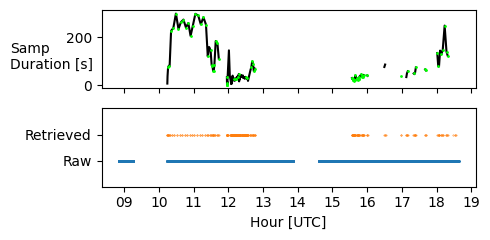

In [36]:
output = process('./data/DASH-flight-2024_05_28/', 'RESAMP_240528')

<AxesSubplot: >

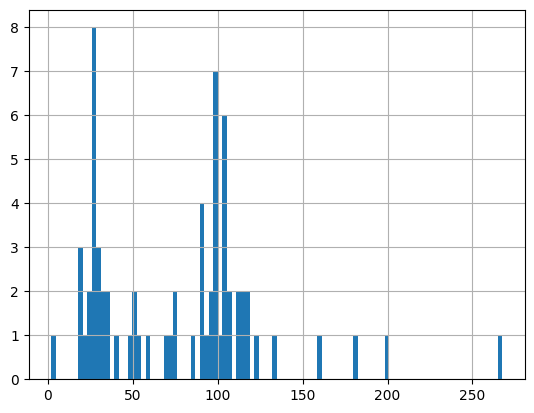

In [ ]:
output['Samp_Time_s'].hist(bins=100)

<AxesSubplot: xlabel='Start_Date_Time_UTC', ylabel='Samp_Time_s'>

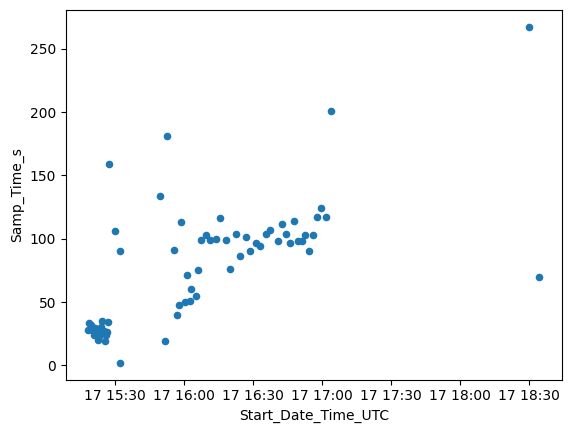

In [ ]:
output.plot.scatter(x='Start_Date_Time_UTC', y='Samp_Time_s')